<a href="https://colab.research.google.com/github/antoniogonzalezai/Brain-Tumor-Progression-CNN/blob/main/Brain_Tumor_Progression__CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor Progression**

This collection includes datasets from 20 subjects with primary newly diagnosed glioblastoma who were treated with surgery and standard concomitant chemo-radiation therapy (CRT) followed by adjuvant chemotherapy.  Two MRI exams are included for each patient: within 90 days following CRT completion and at progression (determined clinically, and based on a combination of clinical performance and/or imaging findings, and punctuated by a change in treatment or intervention). 
All image sets are in DICOM format and contain T1w (pre and post-contrast agent), FLAIR, T2w, ADC, normalized cerebral blood flow, normalized relative cerebral blood volume, standardized relative cerebral blood volume, and binary tumor masks (generated using T1w images).  The perfusion images were generated from dynamic susceptibility contrast (GRE-EPI DSC) imaging following a preload of contrast agent.  All of the series are co-registered with the T1+C images.  The intent of this dataset is for assessing deep learning algorithm performance to predict tumor progression.


Schmainda KM, Prah M (2018). Data from Brain-Tumor-Progression. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2018.15quzvnb 


Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7

In [ ]:
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

## **Load data**

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gsutil cp gs://neurasys-datasets/Brain_Tumor_Progression/Brain_Tumor_Progression.rar .

In [ ]:
!unrar x /content/Brain_Tumor_Progression.rar

# **Create a dataset**

In [ ]:
image_size = (150,150)

batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Brain_Tumor_Progression",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Brain_Tumor_Progression",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


0.   Label 0 = FLuid-Attenuated Inversion Recovery(FLAIR)
1.   Label 1 =  T2 Regresion
2.   Label 2 = Adenocarcinoma(ADC)
3.   Label 3 = DT 1
4.   Label 4 = Normalized cerebral blood flow(nCB)
6.   Labe 6 =  normalized relative cerebral blood volume(nRCBVreg)
7.   Label 7 = post-contrast agent(T1)
8.   Label 8 = pre-contrast agent(T1)
9.   Label 9 = standardized relative cerebral blood volume(sRCBVreg)

In [ ]:
class_names = ['FLAIR','T2','Adenocarcinoma','DT1','NCB','NRCB','T1 POST CONTRAST','T1 PRE CONTRAST','SRCB']

# **Visualize the data**

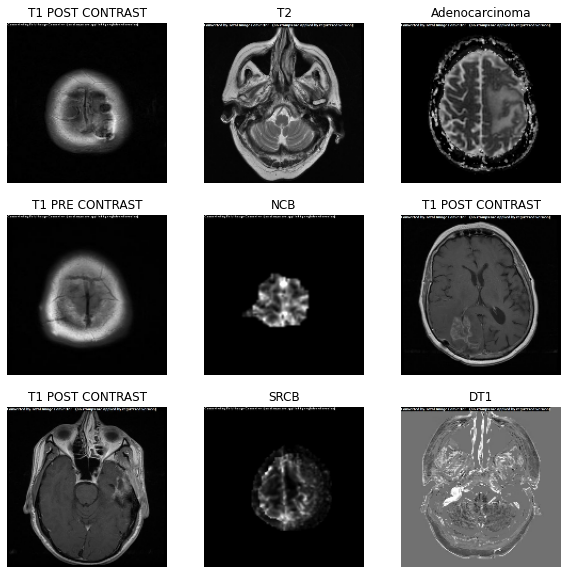

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

## **Data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## **Configure the dataset for performance**

In [ ]:
input_shape =(150,150,3)

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

## **Create the model**

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(9)
])

## **Compile the model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## **Train the model**

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

## **Visualize training results**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Predictions**

In [ ]:
X = "/content/Brain_Tumor_Progression/post-contrast agent(T1)/1-10 (39).jpg"

In [ ]:
img = keras.preprocessing.image.load_img(
    X, target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

y = cv2.imread(X)
y = cv2.cvtColor(y,cv2.COLOR_BGR2RGB)
plt.imshow(np.squeeze(y))
plt.show()